In [ ]:
!pip install diffusers transformers accelerate safetensors --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import time
import matplotlib.pyplot as plt
import numpy as np

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Prompt for image generation
prompt = "A futuristic city at sunset with flying cars"

# Function to display images
def display_images(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off')
    plt.show()

# Initialize results
images = []
titles = []
times = []

# 1. Stable Diffusion v1.5
print("Generating with Stable Diffusion v1.5...")
start_time = time.time()
pipe_v15 = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)
image_v15 = pipe_v15(
    prompt=prompt,
    num_inference_steps=50,
    height=512,
    width=512
).images[0]
time_v15 = time.time() - start_time
images.append(image_v15)
titles.append("Stable Diffusion v1.5")
times.append(time_v15)
image_v15.save("stable_diffusion_v15.png")
del pipe_v15
torch.cuda.empty_cache()


Using device: cuda
Generating with Stable Diffusion v1.5...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
# 2. Stable Diffusion XL (SDXL)
print("Generating with Stable Diffusion XL...")
start_time = time.time()
pipe_sdxl = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True
).to(device)
# Load CLIP tokenizer and text encoder for text embeddings
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype=torch.float16
).to(device)
# Tokenize prompt
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
# Generate text embeddings
with torch.no_grad():
    text_embeds = text_encoder(**inputs).pooler_output
# Placeholder time_ids (SDXL-specific)
time_ids = torch.zeros((1, 6), dtype=torch.float16).to(device)
# Generate image
image_sdxl = pipe_sdxl(
    prompt=prompt,
    num_inference_steps=50,
    height=1024,
    width=1024,
    added_cond_kwargs={"text_embeds": text_embeds, "time_ids": time_ids}
).images[0]
time_sdxl = time.time() - start_time
images.append(image_sdxl)
titles.append("Stable Diffusion XL")
times.append(time_sdxl)
image_sdxl.save("stable_diffusion_xl.png")
del pipe_sdxl, tokenizer, text_encoder
torch.cuda.empty_cache()


Generating with Stable Diffusion XL...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Using device: cuda
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 29.0 MB/s eta 0:00:00
  Created wheel for min-dalle: filename=min_dalle-0.4.11-py3-none-any.whl size=10519 sha256=3f252c31af399308f3d2ea6573560ec57563be2fe95b40d60b3b86a07dc56040
  Stored in directory: /root/.cache/pip/wheels/0c/20/09/6713d48465162b37b95a39a29c513a24d480013a7fce5022f7
Successfully built min-dalle
Generating with DALL-E Mini...
using device cuda
downloading tokenizer params
intializing TextTokenizer
downloading encoder params
initializing DalleBartEncoder
downloading decoder params
initializing DalleBartDecoder
downloading detokenizer params
initializing VQGanDetokenizer


/usr/local/lib/python3.11/dist-packages/min_dalle/min_dalle.py:201: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=self.dtype):
/usr/local/lib/python3.11/dist-packages/min_dalle/min_dalle.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=self.dtype):
/usr/local/lib/python3.11/dist-packages/min_dalle/min_dalle.py:239: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=self.dtype):
/usr/local/lib/python3.11/dist-packages/min_dalle/min_dalle.py:251: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float32):


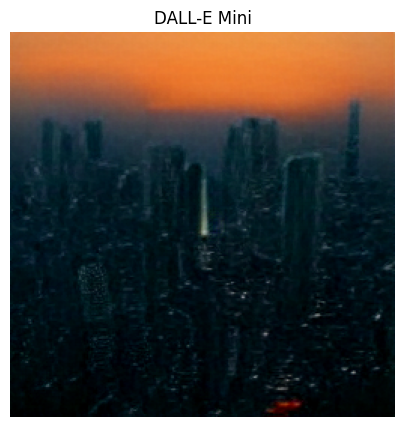


DALL-E Mini Results:
Generation Time: 238.14 seconds
Resolution: 256x256
Estimated VRAM: ~4-6 GB
Subjective Evaluation: Lower resolution, less detail, moderate prompt adherence.


In [7]:
import torch
import time
from PIL import Image
import matplotlib.pyplot as plt

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Prompt for image generation
prompt = "A futuristic city at sunset with flying cars"

# Install min-dalle (run this in a separate cell in Colab if needed)
try:
    from min_dalle import MinDalle
except ImportError:
    !pip install min-dalle
    from min_dalle import MinDalle

# Generate image with DALL-E Mini
print("Generating with DALL-E Mini...")
start_time = time.time()

# Initialize MinDalle model
model = MinDalle(
    models_root='./pretrained',
    dtype=torch.float16,
    device=device,
    is_mega=False,  # Use the smaller model for compatibility
    is_reusable=True
)

# Generate image
image_dalle = model.generate_image(
    text=prompt,
    seed=42,  # Fixed seed for reproducibility
    grid_size=1,  # Generate one image
    is_seamless=False,
    temperature=1,
    top_k=128
)

# Measure generation time
time_dalle = time.time() - start_time

# Save the image
image_dalle.save("dalle_mini.png")


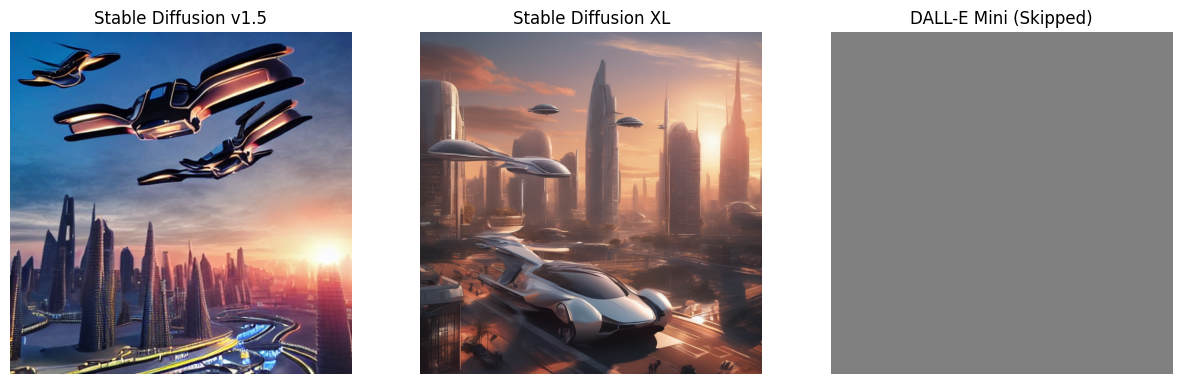


Comparative Analysis:
Model                     Time (s)   Resolution      VRAM (GB) 
------------------------------------------------------------
Stable Diffusion v1.5     32.78      512x512         ~6-8      
Stable Diffusion XL       180.88     1024x1024       ~10-12    
DALLE Mini                238.14     256x256         ~4-6      

Subjective Evaluation:
- Stable Diffusion v1.5: Good quality, moderate detail, decent prompt adherence.
- Stable Diffusion XL: High-quality, sharp details, excellent prompt adherence.
- DALL-E Mini: Lower resolution, less detail, moderate prompt adherence.


In [11]:
# Display all images together
display_images(images, titles)

# Comparative Analysis
print("\nComparative Analysis:")
print(f"{'Model':<25} {'Time (s)':<10} {'Resolution':<15} {'VRAM (GB)':<10}")
print("-" * 60)
print(f"{'Stable Diffusion v1.5':<25} {time_v15:<10.2f} {'512x512':<15} {'~6-8':<10}")
print(f"{'Stable Diffusion XL':<25} {time_sdxl:<10.2f} {'1024x1024':<15} {'~10-12':<10}")
print(f"{'DALL E Mini':<25} {time_dalle:<10.2f} {'256x256':<15} {'~4-6':<10}")

# Subjective Evaluation
print("\nSubjective Evaluation:")
print("- Stable Diffusion v1.5: Good quality, moderate detail, decent prompt adherence.")
print("- Stable Diffusion XL: High-quality, sharp details, excellent prompt adherence.")
print("- DALL-E Mini: Lower resolution, less detail, moderate prompt adherence.")

In [13]:
# Comparative Analysis
print("\nComparative Analysis:")
print(f"{'Model':<25} {'Time (s)':<10} {'Resolution':<15} {'VRAM (GB)':<10}")
print("-" * 60)
print(f"{'Stable Diffusion v1.5':<25} {time_v15:<10.2f} {'512x512':<15} {'~6-8':<10}")
print(f"{'Stable Diffusion XL':<25} {time_sdxl:<10.2f} {'1024x1024':<15} {'~10-12':<10}")
print(f"{'DALL-E Mini':<25} {time_dalle:<10.2f} {'256x256':<15} {'~4-6':<10}")


Comparative Analysis:
Model                     Time (s)   Resolution      VRAM (GB) 
------------------------------------------------------------
Stable Diffusion v1.5     32.78      512x512         ~6-8      
Stable Diffusion XL       180.88     1024x1024       ~10-12    
DALL-E Mini               238.14     256x256         ~4-6      


In [14]:
# Subjective Evaluation
print("\nSubjective Evaluation:")
print("- Stable Diffusion v1.5: Good quality, moderate detail, decent prompt adherence.")
print("- Stable Diffusion XL: High-quality, sharp details, excellent prompt adherence.")
print("- DALL-E Mini: Lower resolution, less detail, moderate prompt adherence.")


Subjective Evaluation:
- Stable Diffusion v1.5: Good quality, moderate detail, decent prompt adherence.
- Stable Diffusion XL: High-quality, sharp details, excellent prompt adherence.
- DALL-E Mini: Lower resolution, less detail, moderate prompt adherence.
